In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import fft
import cv2
import matplotlib.pyplot as plt

import diffractsim as ds

mm_ = 1e-3
um_ = 1e-6
nm_ = 1e-9

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(834, 782, 3)
(834, 782)
(4096, 4096)


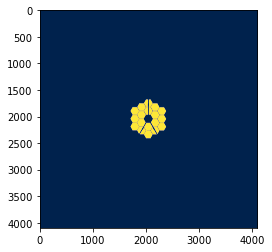

In [16]:
aperture_jwst = cv2.imread('images/JWIST_BW_mirrors.png')
print(aperture_jwst.shape)
aperture_jwst = aperture_jwst.mean(axis=2) # rgb to single channel
print(aperture_jwst.shape)


# binarize
thresh = 240
aperture_jwst[aperture_jwst<thresh] = 0
aperture_jwst[aperture_jwst>thresh] = 255


def pad_next2( arr, augmentfactor=1 ):
    '''
    pad array to the next power of 2 for faster FFT
    '''
    nsize = 2**(int(np.log2(augmentfactor*np.max(arr.shape))) + 1)
    npad_diff = nsize - np.array(arr.shape)
    npad = npad_diff//2
    
    arr = np.pad(arr, [[npad[0], npad[0] + npad_diff[0]%2], [npad[1], npad[1] + npad_diff[1]%2]])

    return arr

aperture_jwst = pad_next2(aperture_jwst, augmentfactor=4)
print(aperture_jwst.shape)

plt.imshow(aperture_jwst, cmap='cividis')

# Propagation


In [17]:
def rect2d(xx, yy, xwidth, ywidth, zeroval=0.0):
    
    zz  = np.heaviside( -(xx - xx.shape[1]/2 - xwidth/2), zeroval)
    zz *= np.heaviside( xx - xx.shape[1]/2 + xwidth/2, zeroval)
    zz *= np.heaviside( -(yy - yy.shape[0]/2 - ywidth/2), zeroval)
    zz *= np.heaviside( yy - yy.shape[0]/2 + ywidth/2, zeroval)

    return zz
def prop_fresnel( U_0, opl, wavelen, px_size ):
    '''
    H(f_x, f_y) = e^{ikz} e^{-i\pi\lambda(f_x^2, f_y^2)}
    '''
    # source array size
    Nx, Ny = U_0.shape
    opl_max_TF = (Nx*px_size**2) / wavelen
    if opl > opl_max_TF:
        print(f'Validity of calculation warning: OPL = {opl:0.6f} m > OPL_max = {opl_max_TF:0.6f} m')
    else:
        print(f'Calculation in validity region: OPL = {opl:0.6f} m < OPL_max = {opl_max_TF:0.6f} m')

    wavenum = 2*np.pi/wavelen # wave number, k

    # spatial frequencies
    fmax = 0.5*(1/px_size) # max spatial frequency in FFT
    delta_fx = 1 / (Nx*px_size)
    delta_fy = 1 / (Ny*px_size)
    fx = np.linspace( -fmax, fmax-delta_fx, Nx )
    fy = np.linspace( -fmax, fmax-delta_fy, Ny )
    ffx, ffy = np.meshgrid(fx, fy, indexing='xy')
    
    # Fresnel transfer function eval at fx, fy
    fresnel_TF = np.exp(-1j*np.pi*opl*(ffx**2 + ffy**2))
    fresnel_TF = fft.fftshift( fresnel_TF )

    # FFT of source field
    U_0_fft = fft.fft2( fft.fftshift(U_0) )
    # multiply in Fourier space
    U_1_fft = U_0_fft * fresnel_TF
    # invert FFT
    U_1 = fft.ifftshift( fft.ifft2(U_1_fft) )
    # U_1 = ( fft.ifft2(U_1_fft) )

    return U_1, fresnel_TF, U_0_fft, U_1_fft

def diffract_size( wavelen, source_halfwidth, smallest_feature_halfwidth, distance ):
    '''
    From the angular spectrum formulation, a square will have a sinc(angle) type of angular spectrum. The angle at sinc's first zero is used to estimate the diffration angle in the observation plane.


    '''

    ang_diffract = np.arccos( wavelen / (2*smallest_feature_halfwidth) )
    print(f'angle = {np.rad2deg(ang_diffract):0.3f} deg')
    observation_plane_extent_min = source_halfwidth + distance*np.tan( np.pi/2 - ang_diffract )

    return observation_plane_extent_min


def prop_angspect( U_0, opl, wavelen, px_size ):
    '''
    Propagate source plane using Angular spectrum approach.
    '''
    wavenum = 2*np.pi/wavelen
    
    Nx, Ny = U_0.shape
    
    A_0 = fft.fftshift(fft.fft2( U_0 ) ) # angular spectrum of init intensity

    fx = fft.fftshift(fft.fftfreq( Nx, d=px_size ))
    fy = fft.fftshift(fft.fftfreq( Ny, d=px_size ))

    ffx,ffy = np.meshgrid(fx, fy)

    musquare = wavenum**2 - (2*np.pi)**2 * (ffx**2 + ffy**2)
    # propagating and evenescent waves
    temp = np.sqrt(np.abs(musquare))
    mu = np.where(musquare >= 0, temp, 1j*temp)
    
    # calc angular spectrum at Z
    A_z = A_0 * np.exp(1j * opl * mu)
    
    U_z = fft.ifft2( fft.ifftshift( A_z) )

    return U_z, A_0, A_z




## Angular spectrum approach

__Ersoy - Diffraction, Fourier optics, and imaging 2007__


### Continuous formulation

Angular spectrum formulation of wave propagation.

$$ A(f_x,f_y, z) = \mathbb{F^{-1}}[ U(x,y,z) ] $$

The amplitude function $U(x,y,z)$ satisfies the Helmholtz equation derived for EM waves in isotropic media i.e. 

$$ (\nabla^2 + k^2)U(x,y,z) = 0 $$

Inserting the angular spectrum representation of U into the Helmholtz eq:
$$ (\nabla^2 + k^2)\mathbb{F}[ A(f_x, f_y, z) ] = 0$$
$$ \int\int (\nabla^2_{x,y,z} + k^2)A(f_x, f_y, z) e^{i2\pi(f_x x + f_y y)} df_x df_y = 0$$

Taking the x and y derivatives, the integrand has to be itself equal to zero for the equation to be satisfied regardless of A. 

$$ \frac{d^2}{dz^2}A(f_x, f_y, z) + (k^2 -4\pi^2(f_x^2 + f_y^2))A(f_x, f_y, z) = 0 $$

The solution to this differential equation is: 
$$ A(f_x, f_y, z) = A(f_x, f_y, 0)e^{i\mu z} $$
, where $\mu = \sqrt{k^2 -4\pi^2(f_x^2 + f_y^2)} = k_z$

If the angular spectrum of the field amplitude is known at some earlier point in z, then it can be propagated by the above relation. The amplitude at this later point is obtained by the Fourier transform of $A(f_x, f_y, z)$.

$$ U(x,y,z) = \mathbb{F}\Big[ A(f_x, f_y, 0)e^{i\mu z} \Big] = \mathbb{F}\Big[ \mathbb{F^{-1}}[ U(x,y,z) ]e^{i\mu z} \Big]  $$

At this point, limit the region of interest to the circular region where:
$$ 4\pi^2(f_x^2 + f_y^2) \le k^2 $$
and looking at distances in the far-field so that $z\gg\lambda$ and evenascent waves are negligible. 

### FFT (discrete and practical stuff)

The discrete representation of the U and A functions can be written as:
$$ U(\Delta x n_x, \Delta y n_y, z) = U(\Delta s n_x, \Delta s n_y, z)$$ 
$$ A(\Delta f_x m_x, \Delta f_y m_y, z) = A(\Delta f m_x, \Delta f m_y, z) $$ 

where we assume that the number of space and frequency points in x and y are the same for simplicity without too much loss of generalization i.e. $N_x=N_y=N, M_x=M_y=M$ 
$$ -N \le n_x, n_y \le N$$
$$ -M \le m_x, m_y \le M$$

An approximation that satisfies the inequality $ 4\pi^2(f_x^2 + f_y^2) \le k^2 $, is to take the rectangular region in Fourier space such that: 
$$ 2\pi|f_{max}| = 2\pi\Delta f M \le k $$

Again, assuming that x,y directions are the

From here, we can conclude that the spatial frequency resolution, $\Delta f$, of the FFT is:
$$ \Delta f \le \frac{1}{\lambda M} $$
, where $\lambda = 2\pi/k$ is the wavelength of the electric field whose amplitude is described by U.
  
In order to be able to use the FFT, we must satisfy: $\Delta s \Delta f = 1/N$. From here, we obtain a relation between the number of points in the FFT:
$$ N \ge \frac{\lambda}{\Delta s}M $$
M - number of points in the discrete representation of the E-field 

N - number of points in the FFT of the E-field

$\Delta s$ - spatial resolution of the E-field plane-wave front

$\Delta f$ - frequency resolution of the FFT of the E-field plane-wave front

$\lambda$ - wavelength of the E-field plane-wave represented by $U$


angle = 90.000 deg
observation plane half-size minimum = 0.126006 m
observation plane half-size = 6.144000 m


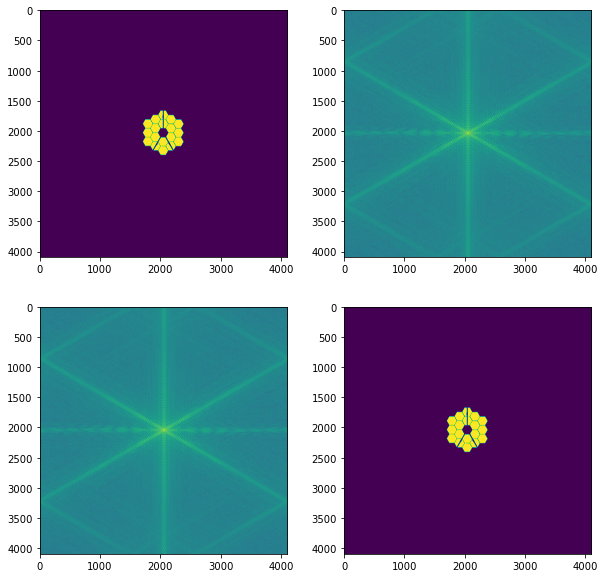

In [18]:
U_WAVELENGTH = 1.510 * um_
U_WAVENUMBER = 2*np.pi / U_WAVELENGTH
U_PIXELPITCH = 6.0 * mm_
U_WIDTH_N_PX = 42
U_SIZE_N = 2048
Z = 1


prop_max_dist = (U_PIXELPITCH*U_SIZE_N*U_PIXELPITCH) / (U_WAVELENGTH)

obsplane_minsize = diffract_size( U_WAVELENGTH, 0.5*U_WIDTH_N_PX*U_PIXELPITCH, 0.5*U_WIDTH_N_PX*U_PIXELPITCH, Z)
print(f'observation plane half-size minimum = {obsplane_minsize:0.6f} m\nobservation plane half-size = {0.5*U_SIZE_N*U_PIXELPITCH:0.6f} m')

# initial intensity
U_0 = (aperture_jwst / 255)  # normalize to (0,1)

# rr,cc = np.meshgrid(np.arange(U_SIZE_N), np.arange(U_SIZE_N))
# U_0 = rect2d(rr,cc, U_WIDTH_N_PX,U_WIDTH_N_PX)

U_z, A_0, A_z = prop_angspect( U_0, Z, U_WAVELENGTH, U_PIXELPITCH )


fig, ((ax_u0, ax_a0), (ax_az, ax_uz)) = plt.subplots(2,2, figsize=(10,10))

ax_u0.imshow(np.abs(U_0))

ax_a0.imshow( np.log10(np.abs(A_0)) )

ax_az.imshow( np.log10(np.abs(A_z)) )

ax_uz.imshow( np.abs(U_z) )
plt.show()



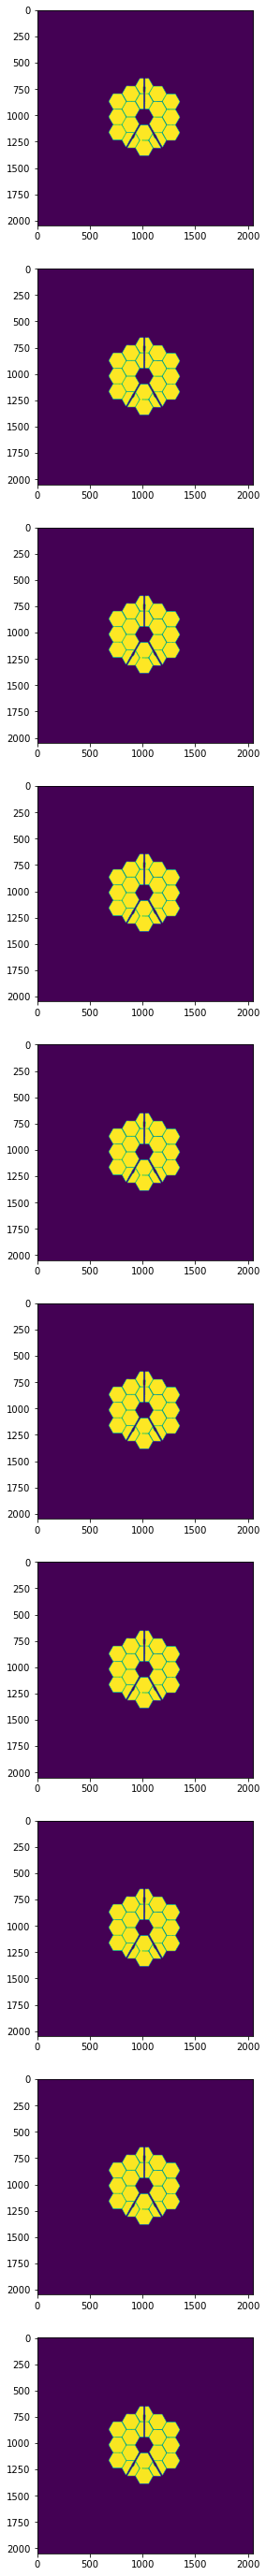

In [15]:
Nz = 10
fig, axs = plt.subplots(Nz, 1, figsize=(5,50))
for i,z in enumerate(np.linspace(0.0, 5.0, Nz)):
    E_z, A_0, A_z = prop_angspect( U_0, z, U_WAVELENGTH, U_PIXELPITCH )
    U_z = np.real(E_z * np.conjugate(E_z) )
    # axs[i].imshow(np.abs(E_z)**2)
    axs[i].imshow( U_z )


## Fresnel Transfer Function

__Voelz - Computational Fourier Optics 2010__

Due to finite sampling of transfer function, there is aliasing in numerical propagtion schemes.

Transfer function approach is valid when the distance of propagation is relatively short or the wavelength is short.

$$\Delta x > \frac{\lambda z}{L}$$ 
or 
$$ z < \frac{L \Delta x}{\lambda } $$  

where:

$\Delta x = L/M$ - is the sample interval

$\lambda$ - wavelength

$z$ - propagation distance

$L$ - the source plane extent, which must be larger than the source function support $L > D$

$M$ - the size of the source array

The Fresnel transfer function is:
$$ H(f_x, f_y) = e^{ikz} \exp{[-i\pi\lambda z(f_x^2 + f_y^2)]} $$

The second exponential is referred to as the chirp. The spatial frequencies are in the range $[-\frac{1}{2\Delta x}, \frac{1}{2\Delta x}]$ 

The propagation of a source field is then computed by evaluation of:

$$ U(x,y,z) = \mathbb{F^{-1}}\Big[ \mathbb{F}[U(x,y,0)] H(f_x, f_y) \Big] $$


angle = 90.000 deg
observation plane half-size minimum = 0.126006 m
observation plane half-size = 1.536000 m
Calculation in validity region: OPL = 1.000000 m < OPL_max = 12288.000000 m


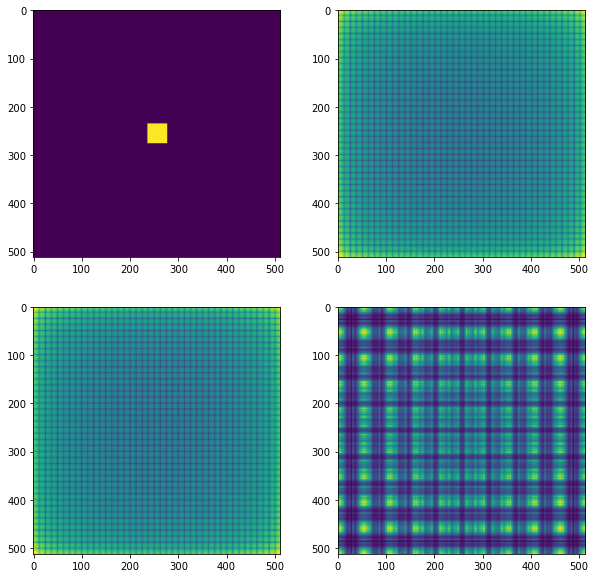

In [237]:
U_WAVELENGTH = 1.500e-6
U_WAVENUMBER = 2*np.pi / U_WAVELENGTH
U_PIXELPITCH = 6.0e-3
U_SIZE_N = 512

U_WIDTH_N_PX = 42

Z = 1

prop_max_dist = (U_PIXELPITCH*U_SIZE_N*U_PIXELPITCH) / (U_WAVELENGTH)

obsplane_minsize = diffract_size( U_WAVELENGTH, 0.5*U_WIDTH_N_PX*U_PIXELPITCH, 0.5*U_WIDTH_N_PX*U_PIXELPITCH, Z)
print(f'observation plane half-size minimum = {obsplane_minsize:0.6f} m\nobservation plane half-size = {0.5*U_SIZE_N*U_PIXELPITCH:0.6f} m')
# initial intensity
# U_0 = (aperture_jwst / 255)  # normalize to (0,1)
rr,cc = np.meshgrid(np.arange(U_SIZE_N), np.arange(U_SIZE_N))

U_0 = rect2d(rr,cc, U_WIDTH_N_PX,U_WIDTH_N_PX)

U_z, fresnel_TF, U_0_fft, U_z_fft = prop_fresnel( U_0, Z, U_WAVELENGTH, U_PIXELPITCH )


fig, ((ax_u0, ax_a0), (ax_az, ax_uz)) = plt.subplots(2,2, figsize=(10,10))

ax_u0.imshow(np.abs(U_0))

ax_a0.imshow( np.log10(np.abs(U_0_fft)) )

ax_az.imshow( np.log10(np.abs(U_z_fft)) )

ax_uz.imshow( np.abs(U_z) )
plt.show()



In [188]:
nx,ny = U_0.shape
print(nx)

512
